# Problem Statement

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster. Take this example:
The author explicitly uses the word “ABLAZE” but means it metaphorically. This is clear to a human right away, especially with the visual aid. But it’s less clear to a machine.

In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t.

# Import all the required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re

In [2]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
import unicodedata
import gensim

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Flatten, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score


[nltk_data] Downloading package stopwords to C:\Users\Adarsh
[nltk_data]     Singh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Adarsh
[nltk_data]     Singh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\Adarsh Singh\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
C:\Users\Adarsh Singh\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)]

## Import the Training data

In [3]:
trn_df = pd.read_csv("C:\\Users\\Adarsh Singh\\Documents\\Deep_Learning\\NLP_Disaster_Prediction\\train.csv")

In [4]:
trn_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Import the Testing data

In [5]:
tst_df = pd.read_csv("C:\\Users\\Adarsh Singh\\Documents\\Deep_Learning\\NLP_Disaster_Prediction\\test.csv")

In [6]:
tst_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
print(len(trn_df))

7613


## Find the Null values in text column which is a target column

In [8]:
trn_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [9]:
tst_df.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [10]:
trn_df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [11]:
dist_val = trn_df['target'].value_counts().to_dict()

In [12]:
labels = list(dist_val.keys())
counts = list(dist_val.values())

## Plot the count of target category to check the balancing of the dataset

Text(0, 0.5, 'Counts')

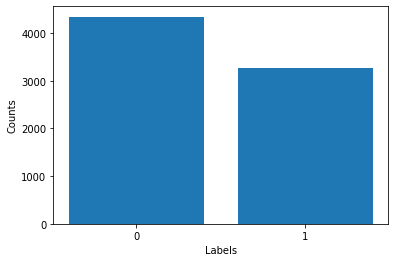

In [13]:
plt.bar(range(len(dist_val)), counts, tick_label=labels)
plt.xlabel("Labels")
plt.ylabel("Counts")

## Convert the text column values to lowercase

In [14]:
trn_df["text"] = trn_df["text"].apply(lambda x: x.lower())

In [15]:
trn_df

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this #earthquake m...,1
1,4,NaN,NaN,forest fire near la ronge sask. canada,1
2,5,NaN,NaN,all residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,just got sent this photo from ruby #alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @thetawniest the out of control w...,1
7610,10871,NaN,NaN,m1.94 [01:04 utc]?5km s of volcano hawaii. htt...,1
7611,10872,NaN,NaN,police investigating after an e-bike collided ...,1


## Using regex pattern remove the mail id from the text

In [16]:
trn_df["text_pre"] = trn_df["text"].apply(lambda x: re.sub("[a-zA-Z0-9.-_]+@[a-zA-Z0-9.-_]+\.[a-zA-Z]+","",x))

In [17]:
trn_df

,id,keyword,location,text,target,text_pre
0,1,NaN,NaN,our deeds are the reason of this #earthquake m...,1,our deeds are the reason of this #earthquake m...
1,4,NaN,NaN,forest fire near la ronge sask. canada,1,forest fire near la ronge sask. canada
2,5,NaN,NaN,all residents asked to 'shelter in place' are ...,1,all residents asked to 'shelter in place' are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or..."
4,7,NaN,NaN,just got sent this photo from ruby #alaska as ...,1,just got sent this photo from ruby #alaska as ...
...,...,...,...,...,...,...
7608,10869,NaN,NaN,two giant cranes holding a bridge collapse int...,1,two giant cranes holding a bridge collapse int...
7609,10870,NaN,NaN,@aria_ahrary @thetawniest the out of control w...,1,@aria_ahrary @thetawniest the out of control w...
7610,10871,NaN,NaN,m1.94 [01:04 utc]?5km s of volcano hawaii. htt...,1,m1.94 [01:04 utc]?5km s of volcano hawaii. htt...
7611,10872,NaN,NaN,police investigating after an e-bike collided ...,1,police investigating after an e-bike collided ...


## Using regex pattern remove the following pattern "@Adarsh" from the text

In [18]:
trn_df["text_pre"] = trn_df["text_pre"].apply(lambda x: re.sub("@[a-zA-Z0-9_.-]+"," ",x))

## Using regex pattern remove the following pattern "#" from the text

In [19]:
trn_df["text_pre"] = trn_df["text_pre"].apply(lambda x: re.sub("#","",x))

In [20]:
trn_df

,id,keyword,location,text,target,text_pre
0,1,NaN,NaN,our deeds are the reason of this #earthquake m...,1,our deeds are the reason of this earthquake ma...
1,4,NaN,NaN,forest fire near la ronge sask. canada,1,forest fire near la ronge sask. canada
2,5,NaN,NaN,all residents asked to 'shelter in place' are ...,1,all residents asked to 'shelter in place' are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive wildfires evacuation ord..."
4,7,NaN,NaN,just got sent this photo from ruby #alaska as ...,1,just got sent this photo from ruby alaska as s...
...,...,...,...,...,...,...
7608,10869,NaN,NaN,two giant cranes holding a bridge collapse int...,1,two giant cranes holding a bridge collapse int...
7609,10870,NaN,NaN,@aria_ahrary @thetawniest the out of control w...,1,the out of control wild fires in californi...
7610,10871,NaN,NaN,m1.94 [01:04 utc]?5km s of volcano hawaii. htt...,1,m1.94 [01:04 utc]?5km s of volcano hawaii. htt...
7611,10872,NaN,NaN,police investigating after an e-bike collided ...,1,police investigating after an e-bike collided ...


## Using regex pattern remove the http links from the text

In [21]:
trn_df["text_pre"] = trn_df["text_pre"].apply(lambda x: re.sub("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+","",x))

## Using regex pattern except the alpha values remove other characters from the text

In [22]:
trn_df["text_pre"] = trn_df["text_pre"].apply(lambda x: re.sub("[^a-zA-Z]"," ",x))

In [23]:
trn_df

,id,keyword,location,text,target,text_pre
0,1,NaN,NaN,our deeds are the reason of this #earthquake m...,1,our deeds are the reason of this earthquake ma...
1,4,NaN,NaN,forest fire near la ronge sask. canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,all residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation ord...
4,7,NaN,NaN,just got sent this photo from ruby #alaska as ...,1,just got sent this photo from ruby alaska as s...
...,...,...,...,...,...,...
7608,10869,NaN,NaN,two giant cranes holding a bridge collapse int...,1,two giant cranes holding a bridge collapse int...
7609,10870,NaN,NaN,@aria_ahrary @thetawniest the out of control w...,1,the out of control wild fires in californi...
7610,10871,NaN,NaN,m1.94 [01:04 utc]?5km s of volcano hawaii. htt...,1,m utc km s of volcano hawaii
7611,10872,NaN,NaN,police investigating after an e-bike collided ...,1,police investigating after an e bike collided ...


In [24]:
trn_df.loc[33:38,["text"]].values

array([['#africanbaze: breaking news:nigeria flag set ablaze in aba. http://t.co/2nndbgwyei'],
       ['crying out for more! set me ablaze'],
       ['on plus side look at the sky last night it was ablaze http://t.co/qqsmshaj3n'],
       ["@phdsquares #mufc they've built so much hype around new acquisitions but i doubt they will set the epl ablaze this season."],
       ['inec office in abia set ablaze - http://t.co/3imaomknna'],
       ['barbados #bridgetown jamaica \x89ûò two cars set ablaze: santa cruz \x89ûó head of the st elizabeth police superintende...  http://t.co/wdueaj8q4j']],
      dtype=object)

In [25]:
trn_df.loc[33:38,["text_pre"]].values

array([['africanbaze  breaking news nigeria flag set ablaze in aba  '],
       ['crying out for more  set me ablaze'],
       ['on plus side look at the sky last night it was ablaze '],
       ['  mufc they ve built so much hype around new acquisitions but i doubt they will set the epl ablaze this season '],
       ['inec office in abia set ablaze   '],
       ['barbados bridgetown jamaica     two cars set ablaze  santa cruz     head of the st elizabeth police superintende     ']],
      dtype=object)

## Unicodedata normalize the text which is in "x89ûò" form

In [26]:
import unicodedata

In [27]:
trn_df["text_pre"] = trn_df["text_pre"].apply(lambda x: unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore'))

In [28]:
trn_df

,id,keyword,location,text,target,text_pre
0,1,NaN,NaN,our deeds are the reason of this #earthquake m...,1,our deeds are the reason of this earthquake ma...
1,4,NaN,NaN,forest fire near la ronge sask. canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,all residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation ord...
4,7,NaN,NaN,just got sent this photo from ruby #alaska as ...,1,just got sent this photo from ruby alaska as s...
...,...,...,...,...,...,...
7608,10869,NaN,NaN,two giant cranes holding a bridge collapse int...,1,two giant cranes holding a bridge collapse int...
7609,10870,NaN,NaN,@aria_ahrary @thetawniest the out of control w...,1,the out of control wild fires in californi...
7610,10871,NaN,NaN,m1.94 [01:04 utc]?5km s of volcano hawaii. htt...,1,m utc km s of volcano hawaii
7611,10872,NaN,NaN,police investigating after an e-bike collided ...,1,police investigating after an e bike collided ...


## Remove the stopwords from the text

In [29]:
trn_df["text_pre"] = trn_df["text_pre"].apply(lambda x: [i for i in x.split() if i not in stopwords.words("english")])

In [30]:
trn_df.head()

,id,keyword,location,text,target,text_pre
0,1,NaN,NaN,our deeds are the reason of this #earthquake m...,1,"[deeds, reason, earthquake, may, allah, forgiv..."
1,4,NaN,NaN,forest fire near la ronge sask. canada,1,"[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,all residents asked to 'shelter in place' are ...,1,"[residents, asked, shelter, place, notified, o..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"[people, receive, wildfires, evacuation, order..."
4,7,NaN,NaN,just got sent this photo from ruby #alaska as ...,1,"[got, sent, photo, ruby, alaska, smoke, wildfi..."


## Perform the Lemmatization on each words

In [31]:
lemmatizer = WordNetLemmatizer()
trn_df["text_pre"] = trn_df["text_pre"].apply(lambda x: [lemmatizer.lemmatize(i) for i in x])

In [32]:
trn_df

,id,keyword,location,text,target,text_pre
0,1,NaN,NaN,our deeds are the reason of this #earthquake m...,1,"[deed, reason, earthquake, may, allah, forgive..."
1,4,NaN,NaN,forest fire near la ronge sask. canada,1,"[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,all residents asked to 'shelter in place' are ...,1,"[resident, asked, shelter, place, notified, of..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"[people, receive, wildfire, evacuation, order,..."
4,7,NaN,NaN,just got sent this photo from ruby #alaska as ...,1,"[got, sent, photo, ruby, alaska, smoke, wildfi..."
...,...,...,...,...,...,...
7608,10869,NaN,NaN,two giant cranes holding a bridge collapse int...,1,"[two, giant, crane, holding, bridge, collapse,..."
7609,10870,NaN,NaN,@aria_ahrary @thetawniest the out of control w...,1,"[control, wild, fire, california, even, northe..."
7610,10871,NaN,NaN,m1.94 [01:04 utc]?5km s of volcano hawaii. htt...,1,"[utc, km, volcano, hawaii]"
7611,10872,NaN,NaN,police investigating after an e-bike collided ...,1,"[police, investigating, e, bike, collided, car..."


In [33]:
trn_df.loc[37:40,["text_pre"]]

,text_pre
37,"[inec, office, abia, set, ablaze]"
38,"[barbados, bridgetown, jamaica, two, car, set,..."
39,"[ablaze, lord]"
40,"[check, nsfw]"


In [34]:
trn_df.loc[35:40,["text"]]

,text
35,on plus side look at the sky last night it was...
36,@phdsquares #mufc they've built so much hype a...
37,inec office in abia set ablaze - http://t.co/3...
38,barbados #bridgetown jamaica ûò two cars set ...
39,ablaze for you lord :d
40,check these out: http://t.co/roi2nsmejj http:/...


## Convert the text column to list of list 

In [35]:
y = trn_df["target"].values
x = trn_df["text_pre"].tolist()

In [36]:
print(x)

[['deed', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'u'], ['forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada'], ['resident', 'asked', 'shelter', 'place', 'notified', 'officer', 'evacuation', 'shelter', 'place', 'order', 'expected'], ['people', 'receive', 'wildfire', 'evacuation', 'order', 'california'], ['got', 'sent', 'photo', 'ruby', 'alaska', 'smoke', 'wildfire', 'pours', 'school'], ['rockyfire', 'update', 'california', 'hwy', 'closed', 'direction', 'due', 'lake', 'county', 'fire', 'cafire', 'wildfire'], ['flood', 'disaster', 'heavy', 'rain', 'cause', 'flash', 'flooding', 'street', 'manitou', 'colorado', 'spring', 'area'], ['top', 'hill', 'see', 'fire', 'wood'], ['emergency', 'evacuation', 'happening', 'building', 'across', 'street'], ['afraid', 'tornado', 'coming', 'area'], ['three', 'people', 'died', 'heat', 'wave', 'far'], ['haha', 'south', 'tampa', 'getting', 'flooded', 'hah', 'wait', 'second', 'live', 'south', 'tampa', 'gonna', 'gonna', 'fvck', 'flooding'], ['ra

In [37]:
y

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [38]:
print(x[0])

['deed', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'u']


## Define the dimension to get the word vector length

In [39]:
dim = 50

## Define the Word2Vec model using window size of 2

In [40]:
wv_model = gensim.models.Word2Vec(sentences=x, vector_size = dim, window = 2, min_count = 1)

In [41]:
len(wv_model.wv)

12661

In [42]:
x

[['deed', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'u'],
 ['forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada'],
 ['resident',
  'asked',
  'shelter',
  'place',
  'notified',
  'officer',
  'evacuation',
  'shelter',
  'place',
  'order',
  'expected'],
 ['people', 'receive', 'wildfire', 'evacuation', 'order', 'california'],
 ['got',
  'sent',
  'photo',
  'ruby',
  'alaska',
  'smoke',
  'wildfire',
  'pours',
  'school'],
 ['rockyfire',
  'update',
  'california',
  'hwy',
  'closed',
  'direction',
  'due',
  'lake',
  'county',
  'fire',
  'cafire',
  'wildfire'],
 ['flood',
  'disaster',
  'heavy',
  'rain',
  'cause',
  'flash',
  'flooding',
  'street',
  'manitou',
  'colorado',
  'spring',
  'area'],
 ['top', 'hill', 'see', 'fire', 'wood'],
 ['emergency', 'evacuation', 'happening', 'building', 'across', 'street'],
 ['afraid', 'tornado', 'coming', 'area'],
 ['three', 'people', 'died', 'heat', 'wave', 'far'],
 ['haha',
  'south',
  'tampa',
  'getting',
  'flood

## Intialize the tokenizer object to get sentence sequence

In [43]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x)


In [44]:
x = tokenizer.texts_to_sequences(x)
tokenizer.word_index

{'fire': 1,
 'like': 2,
 'amp': 3,
 'u': 4,
 'get': 5,
 'new': 6,
 'via': 7,
 'one': 8,
 'news': 9,
 'people': 10,
 'time': 11,
 'year': 12,
 'video': 13,
 'disaster': 14,
 'emergency': 15,
 'body': 16,
 'day': 17,
 'home': 18,
 'police': 19,
 'building': 20,
 'would': 21,
 'family': 22,
 'life': 23,
 'go': 24,
 'say': 25,
 'still': 26,
 'storm': 27,
 'crash': 28,
 'back': 29,
 'california': 30,
 'burning': 31,
 'bomb': 32,
 'look': 33,
 'know': 34,
 'suicide': 35,
 'man': 36,
 'death': 37,
 'world': 38,
 'flood': 39,
 'car': 40,
 'train': 41,
 'got': 42,
 'see': 43,
 'rt': 44,
 'attack': 45,
 'first': 46,
 'love': 47,
 'two': 48,
 'make': 49,
 'going': 50,
 'nuclear': 51,
 'pm': 52,
 'today': 53,
 'let': 54,
 'war': 55,
 'killed': 56,
 'accident': 57,
 'dead': 58,
 'w': 59,
 'want': 60,
 'hiroshima': 61,
 'gt': 62,
 'full': 63,
 'need': 64,
 'woman': 65,
 'old': 66,
 'take': 67,
 'way': 68,
 'good': 69,
 'think': 70,
 'weapon': 71,
 'may': 72,
 'injury': 73,
 'watch': 74,
 'bag': 75,


In [45]:
x

[[3889, 462, 165, 72, 1403, 3890, 4],
 [108, 1, 146, 574, 5664, 5665, 1068],
 [1522, 1404, 1686, 463, 5666, 321, 166, 1686, 463, 322, 957],
 [10, 3891, 80, 166, 322, 30],
 [42, 1069, 106, 5667, 1687, 190, 80, 5668, 98],
 [2534, 182, 30, 1220, 729, 958, 464, 905, 323, 1, 3892, 80],
 [39, 14, 702, 158, 125, 703, 183, 448, 5669, 906, 811, 132],
 [138, 1150, 43, 1, 1884],
 [15, 166, 1070, 20, 730, 448],
 [2152, 290, 171, 132],
 [465, 10, 531, 196, 128, 532],
 [731,
  449,
  2535,
  147,
  2536,
  3075,
  533,
  362,
  119,
  449,
  2535,
  241,
  241,
  5670,
  183],
 [2537, 183, 1405, 5671, 2535, 17, 591, 3893],
 [39, 3894, 767, 1406, 3894],
 [126, 98, 197, 2538, 40, 28, 257],
 [36],
 [47, 1523],
 [230, 1524],
 [40, 636],
 [5672],
 [2539],
 [855, 424],
 [47, 5673],
 [2153, 17],
 [5674],
 [68, 1688, 148],
 [1151, 77, 214],
 [47, 1885],
 [5675],
 [2, 3895],
 [184],
 [2540, 307, 534],
 [215, 670, 856, 702, 1071, 44],
 [5676, 257, 9, 2154, 592, 172, 534, 1014],
 [812, 172, 534],
 [1525, 575, 

In [46]:
length = [len(i) for i in x]
min(length)

0

In [47]:
max(length)

23

## Convert each word sequence to padded sequence to get the same length

In [48]:
max_len = 30
x = pad_sequences(x, maxlen = max_len)

In [49]:
x

array([[   0,    0,    0, ..., 1403, 3890,    4],
       [   0,    0,    0, ..., 5664, 5665, 1068],
       [   0,    0,    0, ...,  463,  322,  957],
       ...,
       [   0,    0,    0, ...,  526,  417, 1392],
       [   0,    0,    0, ...,   23, 1792,   73],
       [   0,    0,    0, ...,   80,  587,    9]])

## Define the vocabulary size

In [50]:
vocab_size = 20000
vocab = tokenizer.word_index

## Define the method to get the word vector

In [51]:
def weigth_met(model):
    weigthed_mat = np.zeros((vocab_size, dim))
    for word, i in vocab.items():
        weigthed_mat[i] = model.wv[word]
    return weigthed_mat

In [52]:
embd_vect = weigth_met(wv_model)

In [53]:
embd_vect.shape

(20000, 50)

In [54]:
embd_vect

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.02354625,  0.02320546,  0.02148682, ..., -0.05347951,
         0.10229118,  0.15263782],
       [-0.00128315,  0.02953702, -0.00180816, ..., -0.11777449,
         0.09132434,  0.13716519],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

## Build the model using LSTM Bi-Directional and Train Embedding layer and feed word vector as weight

In [55]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim = dim, weights = [embd_vect], input_length = max_len))
model.add(Bidirectional(LSTM(units = 100)))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Model Summary

In [56]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 50)            1000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               120800    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 1,121,001
Trainable params: 1,121,001
Non-trainable params: 0
_________________________________________________________________


## Train the model to get the best accuracy

In [57]:
x_train, x_test, y_train, y_test = train_test_split(x,y)

In [58]:
model.fit(x, y, validation_data = (x_test,y_test), epochs = 15, batch_size = 64)

Train on 7613 samples, validate on 1904 samples
Epoch 1/15
7613/7613 [==============================] - 13s 2ms/sample - loss: 0.5677 - acc: 0.6941 - val_loss: 0.3476 - val_acc: 0.8540
Epoch 2/15
7613/7613 [==============================] - 9s 1ms/sample - loss: 0.3296 - acc: 0.8638 - val_loss: 0.2046 - val_acc: 0.9343
Epoch 3/15
7613/7613 [==============================] - 11s 1ms/sample - loss: 0.2139 - acc: 0.9182 - val_loss: 0.1281 - val_acc: 0.9527
Epoch 4/15
7613/7613 [==============================] - 11s 1ms/sample - loss: 0.1565 - acc: 0.9439 - val_loss: 0.0908 - val_acc: 0.9669
Epoch 5/15
7613/7613 [==============================] - 10s 1ms/sample - loss: 0.1216 - acc: 0.9577 - val_loss: 0.0813 - val_acc: 0.9706
Epoch 6/15
7613/7613 [==============================] - 11s 1ms/sample - loss: 0.0984 - acc: 0.9672 - val_loss: 0.0683 - val_acc: 0.9737
Epoch 7/15
7613/7613 [==============================] - 11s 1ms/sample - loss: 0.0859 - acc: 0.9691 - val_loss: 0.0609 - val_acc: 0

## Predict the output for x_test

In [59]:
y_pred = (model.predict(x_test)>=0.5).astype('int')

In [60]:
y_pred

array([[0],
       [1],
       [0],
       ...,
       [0],
       [1],
       [0]])

In [61]:
accuracy_score(y_test, y_pred)

0.9642857142857143

### As per the accuracy, successfully built the model.

## Define the method to process the test data

In [62]:
def pre_processing(df):
    df["text"] = df["text"].apply(lambda x: x.lower())
    df["text_pre"] = df["text"].apply(lambda x: re.sub("[a-zA-Z0-9.-_]+@[a-zA-Z0-9.-_]+\.[a-zA-Z]+","",x))
    df["text_pre"] = df["text_pre"].apply(lambda x: re.sub("@[a-zA-Z0-9_.-]+"," ",x))
    df["text_pre"] = df["text_pre"].apply(lambda x: re.sub("#","",x))
    df["text_pre"] = df["text_pre"].apply(lambda x: re.sub("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+","",x))
    df["text_pre"] = df["text_pre"].apply(lambda x: re.sub("[^a-zA-Z]"," ",x))
    df["text_pre"] = df["text_pre"].apply(lambda x: unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore'))
    df["text_pre"] = df["text_pre"].apply(lambda x: [i for i in x.split() if i not in stopwords.words("english")])
    df["text_pre"] = df["text_pre"].apply(lambda x: [lemmatizer.lemmatize(i) for i in x])
    x = df["text_pre"].tolist()
    x = tokenizer.texts_to_sequences(x)
    x = pad_sequences(x, maxlen = max_len)
    return x    

In [63]:
result_sample = pre_processing(tst_df)

In [64]:
result_sample

array([[   0,    0,    0, ..., 1709,   40,   28],
       [   0,    0,    0, ...,  432, 1618,  142],
       [   0,    0,    0, ...,  448, 1228,  263],
       ...,
       [   0,    0,    0, ...,  523,  288,  769],
       [   0,    0,    0, ...,  175, 1518, 1679],
       [   0,    0,    0, ...,   15,   85, 3760]])

## Predict the output for test dataset

In [65]:
result = (model.predict(result_sample)>=0.5).astype('int')

In [66]:
result = result.tolist()

In [67]:
temp = []
for i in result:
    for j in i:
        temp.append(j)
        

## Predicted values for test dataset

In [68]:
for i in temp:
    print(i, end = " ")

1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 0 1 0 1 1 1 0 0 1 1 1 1 0 0 0 0 1 0 1 0 1 0 0 1 1 1 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 0 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 1 0 0 1 1 0 0 1 0 0 0 1 0 0 1 1 1 0 0 1 1 0 0 1 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 1 1 1 0 0 0 1 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 1 1 1 1 0 1 0 0 0 1 1 0 1 0 1 1 0 0 0 1 1 1 1 1 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 1 1 

## Created the dataframe to get the result in the requested format

In [69]:
ans = pd.DataFrame(list(zip(tst_df["id"].tolist(), temp)), columns = ["id","target"])

In [70]:
ans

,id,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,0
3260,10868,1
3261,10874,1


In [71]:
ans.set_index("id", inplace=True)

In [72]:
ans

,target
id,
0,1
2,0
3,1
9,1
11,1
...,...
10861,1
10865,0
10868,1


## Store the result set in "sample_submission.csv" file.

In [73]:
ans.to_csv("sample_submission.csv")